In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [7]:
api = wandb.Api()
runs = api.runs('hiue/lowrank-fedrec-2', {
    "$and": [{
        # 'config.data.name': 'movielens',
        # 'config.dataloader.batch_size': 32,
        # 'config.data.name': 'foursq-ny',
        # 'config.task_name': 'fedsweep3',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 5e-3,

        # 'config.data.name': 'foursq-ny',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 7e-3,
        'tags': {
            "$in": ['selected']
        },
        'config.data.name': 'pinterest',
        'config.task_name': 'fedtrain5',    
        # 'state': 'finished'
        }]
})

In [19]:
lora_runs = []
svd_runs = []
normal_runs = []

update_numels = []
all_HR = []
all_NDCG = []
all_loss = []

histories = {}

for run in runs:
    print("Name: {}, Id: {}".format(run.name, run.id))
    if 'lora' in run.name:
        if run.config['model']['init']['lora_rank'] == run.config['model']['init']['lora_alpha']:
            lora_runs.append(run)
        else:
            continue
    elif 'svd' in run.name:
        svd_runs.append(run)
    else:
        normal_runs.append(run)
    update_numels.append(run.summary['update_numel'])
    # histories[run.name] = run.history(samples=20)
    histories[run.name] = run.scan_history(keys=['train_loss', 'HR', 'NDCG', 'epoch'])
    # all_HR.append(run.history()['HR'].max())
    # all_NDCG.append(run.history()['NDCG'].max())
    # all_loss.append(run.history()['train_loss'].min())

Name: fedmf64-550-2-229, Id: 3fk3caxj


Name: fedmf64_lora16_freezeB-550-2-227, Id: 32ll5u72
Name: fedmf64_lora8_freezeB-550-2-226, Id: 2cgjqrz3
Name: fedmf64_lora4_freezeB-550-2-225, Id: 2tcoa9h2


In [20]:
def scatter_plot(ax, runs, metric, label=None, marker='o', linestyle='dashed', color=None, rescale_x=None, min_value=False, text_offset=0.02):
    x = []
    y = []
    for run in runs:
        x_val = run.summary['update_numel']
        if rescale_x is not None:
            x_val = x_val / rescale_x
        x.append(x_val)

        y_val = run.summary[metric]
        # if min_value:
        #     y.append(histories[run.name][metric].min())
        # else:
        #     y.append(histories[run.name][metric].max())
        y.append(y_val)
        # if 'lora' in run.name:
        #     lora_rank = run.config['model']['init']['lora_rank']
        #     # ax.text(x_val, y_val+text_offset, f"r={lora_rank}", fontsize=8)
        #     ax.annotate(f"r={lora_rank}", (x_val, y_val), xytext=(x_val, y_val+text_offset), fontsize=8)
        # else:
        #     emb_size = run.config['model']['init']['gmf_emb_size']
        #     ax.text(x_val, y_val-text_offset, f"d={emb_size}", fontsize=8)

    ids = np.argsort(x)
    x = np.array(x)[ids]
    y = np.array(y)[ids]
    ax.plot(x, y, label=label, marker=marker, linestyle=linestyle, color=color)

Text(0, 0.5, 'Train loss')

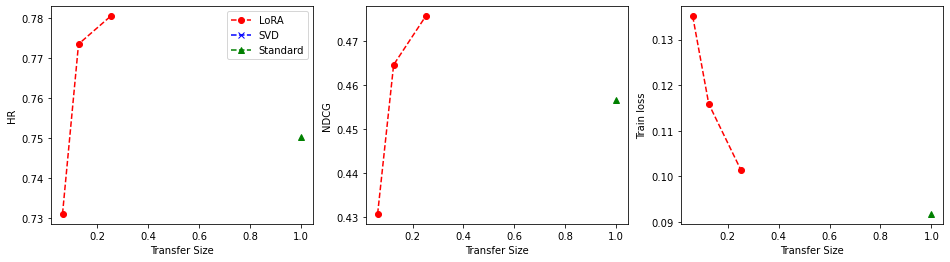

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
scatter_plot(axes[0], lora_runs, 'HR', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.02)
scatter_plot(axes[0], svd_runs, 'HR', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.02)
scatter_plot(axes[0], normal_runs, 'HR', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.02)
axes[0].set_xlabel('Transfer Size')
axes[0].set_ylabel('HR')
axes[0].legend()
# axes[0].set_ylim([0.1, 0.5])
# axes[0].axhline(y=max(all_HR), color='black', linestyle='-.')

scatter_plot(axes[1], lora_runs, 'NDCG', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.01)
scatter_plot(axes[1], svd_runs, 'NDCG', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.01)
scatter_plot(axes[1], normal_runs, 'NDCG', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.01)
axes[1].set_xlabel('Transfer Size')
axes[1].set_ylabel('NDCG')
# axes[1].set_ylim([0.15, 0.3])
# axes[1].axhline(y=max(all_NDCG), color='black', linestyle='-.')


scatter_plot(axes[2], lora_runs, 'train_loss', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], svd_runs, 'train_loss', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], normal_runs, 'train_loss', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
axes[2].set_xlabel('Transfer Size')
axes[2].set_ylabel('Train loss')
# axes[2].set_ylim([0.4, 0.6])

In [38]:
cached_hist = {}
for k, v in histories.items():
    cached_hist[k] = {}
    cached_hist[k]['HR'] = [row['HR'] for row in v]
    cached_hist[k]['NDCG'] = [row['NDCG'] for row in v]
    cached_hist[k]['train_loss'] = [row['train_loss'] for row in v]
    cached_hist[k]['epoch'] = [row['epoch'] for row in v]

In [48]:
def plot_hist(run_name, axes, label, **style_kwargs):
    HR = cached_hist[run_name]['HR']
    NDCG = cached_hist[run_name]['NDCG']
    train_loss = cached_hist[run_name]['train_loss']
    epoch = cached_hist[run_name]['epoch']

    axes[0].plot(epoch, HR, label=label, **style_kwargs)
    axes[0].set_xlabel('Communication Rounds')
    axes[0].set_ylabel('Metric')
    

    axes[1].plot(epoch, NDCG, label=label, **style_kwargs)
    axes[1].set_xlabel('Communication Rounds')
    axes[1].set_ylabel('NDCG')

    axes[2].plot(epoch, train_loss, label=label, **style_kwargs)
    axes[2].set_xlabel('Communication Rounds')
    axes[2].set_ylabel('Train loss')


In [40]:
color_set = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
marker_set = ['o', 'x', '^', 'v', 's', 'p', '*', 'h', 'D', 'P']

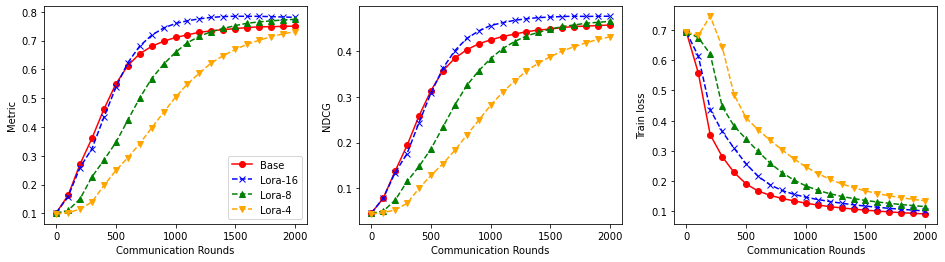

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
style_1 = {'marker':marker_set[0], 'linestyle':'-', 'color':color_set[0]}
plot_hist('fedmf64-550-2-229', axes, label="Base", **style_1)

style_2 = {'marker':marker_set[1], 'linestyle':'--', 'color':color_set[1]}
plot_hist('fedmf64_lora16_freezeB-550-2-227', axes, label="Lora-16", **style_2)

style_3 = {'marker':marker_set[2], 'linestyle':'--', 'color':color_set[2]}
plot_hist('fedmf64_lora8_freezeB-550-2-226', axes, label="Lora-8", **style_3)

style_4 = {'marker':marker_set[3], 'linestyle':'--', 'color':color_set[3]}
plot_hist('fedmf64_lora4_freezeB-550-2-225', axes, label="Lora-4", **style_4)

axes[0].legend()